## Q1

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import open3d as o3d

import json


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Parse Data


In [2]:
# Read RGB images
rgb_image_0 = plt.imread("render_0.png")
rgb_image_1 = plt.imread("render_1.png")

# Read depth images
depth_image_0 = np.load("depth_0.npy")
depth_image_1 = np.load("depth_1.npy")
print(f'rgb length: {rgb_image_0.shape}, depth shape: {depth_image_0.shape}')

# Read poses.json (OpenGL format)
with open('poses.json', 'r') as file:
    poses_data = json.load(file)

# camera pose: [Rc|c] (3x4)
pose0 = np.array(poses_data['pose0'])
pose1 = np.array(poses_data['pose1'])
# camera intrinsic
K = np.array(poses_data['K'])
# image plane
W = poses_data['W']
H = poses_data['H']
print(pose0)

rgb length: (719, 1279, 3), depth shape: (719, 1279, 1)
[[-0.10279863 -0.01021948 -0.99464959 -2.14332652]
 [-0.99469221 -0.00341986  0.10283811  0.79621357]
 [-0.00445252  0.99994195 -0.00981368  1.14122665]]


### (1) Display RGB with Depth Image


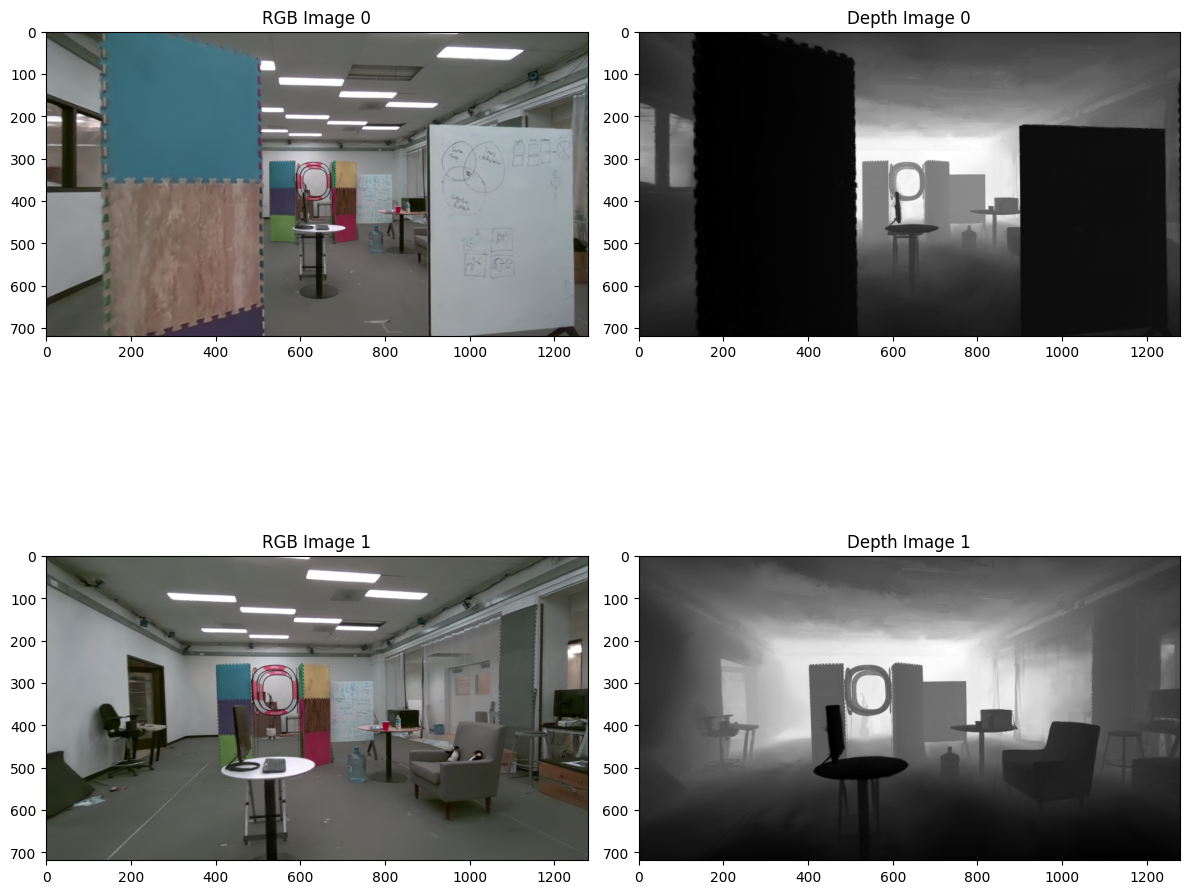

In [27]:


# Display the images
# axe in uv coordinates
fig, axes = plt.subplots(2, 2, figsize=(12, 12))  # Adjusted figsize for clarity
axes[0, 0].imshow(rgb_image_0)
axes[0, 0].set_title('RGB Image 0')

axes[0, 1].imshow(depth_image_0, cmap='gray')
axes[0, 1].set_title('Depth Image 0')

axes[1, 0].imshow(rgb_image_1)
axes[1, 0].set_title('RGB Image 1')

axes[1, 1].imshow(depth_image_1, cmap='gray')
axes[1, 1].set_title('Depth Image 1')

plt.tight_layout()  #



### (2) Colored Point Cloud

#### 2d to 3d (camera frame)

In [4]:
def pixel_to_3d(u, v, depth, K):
    """
    Convert 2D pixel coordinates and depth to 3D coordinates.

    Args:
        u (np.array): The u (horizontal) pixel coordinate. (HxW)
        v (np.array): The v (vertical) pixel coordinate. (HxW, 1)
        depth (np.array): The depth value at pixel (u, v). (H,W,1)
        K (np.array): The camera intrinsic matrix of shape (3, 3).

    Returns:
        np.array: The 3D coordinates [X, Y, Z].
    """
    # Extract camera intrinsic parameters
    f_x = K[0, 0]
    f_y = K[1, 1]
    c_x = K[0, 2]
    c_y = K[1, 2]

    # Calculate 3D coordinates
    X = (u - c_x) / f_x * depth
    Y = (v - c_y) / f_y * depth
    Z = depth

    #
    ones = np.ones_like(X)
    pts_3d_homogeneous = np.stack([X, Y, Z, ones], axis=-1)  # Ensure the last dimension holds [X, Y, Z, 1]

    return pts_3d_homogeneous


#### camera pose convention (OpenGL to OpenCV)

In [14]:
# change camera pose from OpenGL to OpenCV format
def opengl_to_opencv(pose_gl):
    transform = np.array([[1,0,0],
                        [0,-1,0],
                        [0,0,-1]])
    Rc_cv = pose_gl[:3,:3] @ transform
    center = pose_gl[:3,3].reshape(3,1)
    pose_cv = np.hstack([Rc_cv, center])# the translation stays the same, since both opengl and opencv are represented in world frame
    return pose_cv

pose0_cv = opengl_to_opencv(pose0)
pose1_cv = opengl_to_opencv(pose1)
print(f'pose0_cv:\n{pose0_cv} \npose0_gl:\n{pose0}')
print(f'pose1_cv:\n{pose1_cv} \npose1_gl:\n{pose1}')

pose0_cv:
[[-0.10279863  0.01021948  0.99464959 -2.14332652]
 [-0.99469221  0.00341986 -0.10283811  0.79621357]
 [-0.00445252 -0.99994195  0.00981368  1.14122665]] 
pose0_gl:
[[-0.10279863 -0.01021948 -0.99464959 -2.14332652]
 [-0.99469221 -0.00341986  0.10283811  0.79621357]
 [-0.00445252  0.99994195 -0.00981368  1.14122665]]
pose1_cv:
[[-0.20193247 -0.032199    0.97886992 -0.8734808 ]
 [-0.97920346  0.02662847 -0.20112531  0.51503992]
 [-0.01958977 -0.99912667 -0.03690653  1.13496649]] 
pose1_gl:
[[-0.20193247  0.032199   -0.97886992 -0.8734808 ]
 [-0.97920346 -0.02662847  0.20112531  0.51503992]
 [-0.01958977  0.99912667  0.03690653  1.13496649]]


In [23]:
def image_to_pc(rgb_image, depth_image, K, pose_cv):
    # Get the height and width of the depth image
    H, W, _ = depth_image.shape

    # Create a grid of (u, v) coordinates
    u, v = np.meshgrid(np.arange(W), np.arange(H)) # H x W
    u = u.flatten() # (HxW,)
    v = v.flatten() # (HxW,)
    depth_values = depth_image.flatten() # (HxW,)

    # get 3d pcd in world frame (HxW, 1)
    pts_camera = pixel_to_3d(u,v,depth_values,K)
    pose_4x4 = np.vstack((pose_cv, [0, 0, 0, 1]))
    pts_world = (pose_4x4 @ pts_camera.T).T # world = pose @ camera

    # reshape rgb to (HxW, 3)
    rgb = rgb_image[v,u]
    return pts_world[:,:3], rgb


def arr_to_pcd(points, colors=None):
    """
    Convert numpy arrays into an Open3D PointCloud object.
    
    Parameters:
        points (np.array): Numpy array of shape (N, 3) containing XYZ coordinates.
        colors (np.array): Optional numpy array of shape (N, 3) containing RGB values (normalized between 0 and 1).
    
    Returns:
        o3d.geometry.PointCloud: An Open3D point cloud object with points and optionally colors.
    """
    # Create a point cloud object
    pcd = o3d.geometry.PointCloud()

    # Set points
    pcd.points = o3d.utility.Vector3dVector(points)
    
    # Set colors if provided
    if colors is not None:
        pcd.colors = o3d.utility.Vector3dVector(colors)
    
    return pcd


### Visualize PCD

In [24]:
# compute 3d pt in world frame (array)
pcd0_arr, rgb0 = image_to_pc(rgb_image_0,depth_image_0,K, pose0_cv)
pcd1_arr, rgb1 = image_to_pc(rgb_image_1,depth_image_1,K, pose1_cv)

# array to pcd
pcd0 = arr_to_pcd(pcd0_arr, colors=rgb0)
pcd1 = arr_to_pcd(pcd1_arr, colors=rgb1)

# visualize pcd
o3d.visualization.draw_geometries([pcd0], window_name="3D Point Cloud 0")
o3d.visualization.draw_geometries([pcd1], window_name="3D Point Cloud 1")


In [29]:
pcd_combined = pcd0 + pcd1
o3d.visualization.draw_geometries([pcd_combined], window_name="3D Point Cloud Combined")

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 


### (3) CD

In [9]:
from scipy.spatial import KDTree

def chamfer_distance(pc1, pc2):
    """
    Compute the Chamfer distance between two point clouds using KD-tree for efficient nearest neighbor search.
    
    Parameters:
    - pc1, pc2: open3d.geometry.PointCloud objects
    
    Returns:
    - float, the Chamfer distance between pc1 and pc2
    """
    # Convert Open3D PointCloud to numpy arrays
    pc1_points = np.asarray(pc1.points)
    pc2_points = np.asarray(pc2.points)

    # Create a KD-Tree for the second point cloud
    tree2 = KDTree(pc2_points)

    # Find the nearest neighbor in pc2 for each point in pc1
    # min x-y
    distances, _ = tree2.query(pc1_points, workers=-1) # Query the kd-tree for nearest neighbors.
    # print(distances)
    # Compute the one-sided Chamfer distance
    chamfer_dist = np.mean(distances ** 2)
    
    return chamfer_dist


In [28]:
CD = chamfer_distance(pcd0,pcd1) + chamfer_distance(pcd1,pcd0)
print(f'The bidirectional Chamfer distance CD(P1,P2) + CD (P2,P1) is : {CD}')

The bidirectional Chamfer distance CD(P1,P2) + CD (P2,P1) is : 2.2120588022493113
